In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

(<Figure size 500x300 with 1 Axes>, <Axes: >)

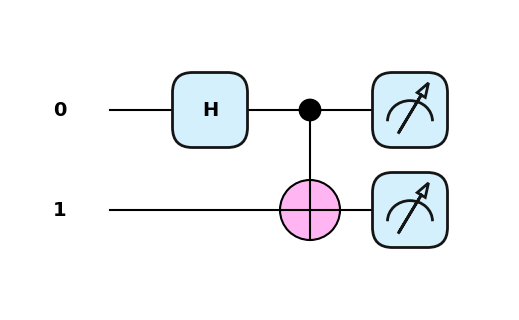

In [2]:

dev = qml.device('default.qubit', wires = 2)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.probs()

qml.draw_mpl(circuit, style ='pennylane')()

In [3]:
%%timeit
circuit()

717 μs ± 52.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [4]:
dev = qml.device('lightning.qubit', wires =2)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.probs()



In [5]:
%%timeit
circuit()

3.02 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
dev = qml.device('lightning.qubit', wires =2, shots = 100)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.probs()



In [7]:
circuit()


array([0.45, 0.  , 0.  , 0.55])

### lienar Combination of Unitaries and block encoding

In [8]:
W = 1/2*np.array([[1, np.sqrt(3)],[np.sqrt(3), 1]])
print(W)




[[0.5       0.8660254]
 [0.8660254 0.5      ]]


In [9]:
LCU = qml.pauli_decompose(W)
LCU_coefs, LCU_ops = LCU.terms()
print(f"LCU decomposition:\n{LCU}")
print(f"Coefficients:\n{LCU_coefs}")
print(f"Unitaries:\n{LCU_ops}")
eye = LCU_ops[0]
# print(eye.matrix())



LCU decomposition:
0.5 * I(0) + 0.8660254037844386 * X(0)
Coefficients:
[0.5       0.8660254]
Unitaries:
[I(0), X(0)]


In [10]:
U = [[ 0.70710678,  0.70710678], 
[ 0.70710678, -0.70710678]]

V = [[1, 0], [0, -1]]
ops = [qml.QubitUnitary(U, wires=1), qml.QubitUnitary(V, wires=1)]

coeffs = [1, 3]

dev1 = qml.device('default.qubit', wires = 1)
alphas = (np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs)))

@qml.qnode(dev1)
def prep_circuit():
    qml.StatePrep(alphas, wires=0)
    return qml.state()
print(ops)
print('target states', alphas)
print('output state', np.real(prep_circuit()))


[QubitUnitary(array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]]), wires=[1]), QubitUnitary(array([[ 1,  0],
       [ 0, -1]]), wires=[1])]
target states [0.5       0.8660254]
output state [0.5       0.8660254]


In [11]:
dev2 = qml.device("default.qubit", wires = 3)
unitaries = [qml.map_wires(op, {0:1}) for op in ops]
print(unitaries)
@qml.qnode(dev2)
def sel_circuit(qubit_value):
    qml.BasisState(qubit_value, wires=0)
    qml.Select(unitaries, control=0)
    return qml.expval(qml.PauliZ(1))

print(sel_circuit([1]))


[QubitUnitary(array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]]), wires=[1]), QubitUnitary(array([[ 1,  0],
       [ 0, -1]]), wires=[1])]
1.0


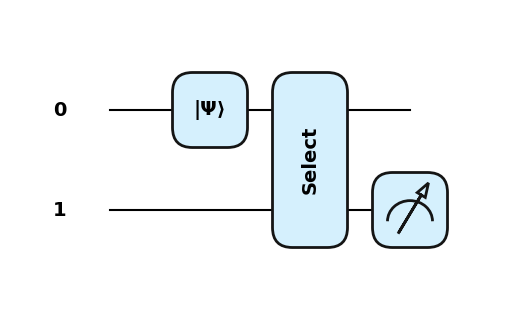

In [12]:
qml.draw_mpl(sel_circuit, style='pennylane')([0])
plt.show()

In [13]:
@qml.qnode(dev2)
def lcu_circuit():

    qml.StatePrep(alphas, wires =0)

    qml.Select(unitaries, control=0)
    qml.adjoint(qml.StatePrep(alphas, wires = 0))
    return qml.state()
output_matrix = qml.matrix(lcu_circuit)()
print(np.real(np.round(output_matrix,7)))

[[ 0.9267767  0.         0.1767767  0.         0.1268265  0.
  -0.3061862  0.       ]
 [ 0.         0.9267767  0.         0.1767767  0.         0.1268265
   0.        -0.3061862]
 [ 0.1767767  0.        -0.9267767  0.        -0.3061862  0.
  -0.1268265  0.       ]
 [ 0.         0.1767767  0.        -0.9267767  0.        -0.3061862
   0.        -0.1268265]
 [ 0.1268265  0.        -0.3061862  0.         0.7803301  0.
   0.5303301  0.       ]
 [ 0.         0.1268265  0.        -0.3061862  0.         0.7803301
   0.         0.5303301]
 [-0.3061862  0.        -0.1268265  0.         0.5303301  0.
  -0.7803301  0.       ]
 [ 0.        -0.3061862  0.        -0.1268265  0.         0.5303301
   0.        -0.7803301]]


### Challenge question

In [14]:
def W(alpha, beta):
    norm = np.sqrt(alpha +  beta)
    matrix = [[np.sqrt(alpha), np.sqrt(beta)], [np.sqrt(beta), -1*np.sqrt(alpha)]] / norm
    return matrix

print(f"The helper W\n{W(1, 3)}")

The helper W
[[ 0.5        0.8660254]
 [ 0.8660254 -0.5      ]]


In [15]:
def linear_combination(U, V, alpha, beta):
    dev = qml.device("default.qubit", wires =2)

    @qml.qnode(dev)
    def circuit():
        qml.QubitUnitary(W(alpha, beta), wires = 0)

        qml.ctrl(qml.QubitUnitary(U, wires =1), control = 0)

        qml.PauliX(0)
        qml.ctrl(qml.QubitUnitary(V, wires=1), control =0)
        qml.PauliX(0)

        return qml.probs(wires = 0)
    
    probs = circuit()
    return probs[0]

print(linear_combination(U, V, 1, 3))

0.25


In [16]:
U = [[ 0.70710678,  0.70710678], 
[ 0.70710678, -0.70710678]]

V = [[1, 0], [0, -1]]
ops1 = [qml.QubitUnitary(U, wires=1), qml.QubitUnitary(V, wires=1)]
unitaries = [qml.map_wires(op, {0:1}) for op in ops1]
coeffs = [1, 3]
alphas = (np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs)))
@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    
    probs = qml.probs(wires = 0)
    return probs

probs = lcu_circuit()
print(probs[0])
# output_matrix = 
print("A:\n", W(coeffs[0], coeffs[1]), "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

0.8901650422902461
A:
 [[ 0.5        0.8660254]
 [ 0.8660254 -0.5      ]] 

Block-encoded A:

[[ 0.93  0.    0.18  0.    0.13  0.   -0.31  0.  ]
 [ 0.    0.93  0.    0.18  0.    0.13  0.   -0.31]
 [ 0.18  0.   -0.93  0.   -0.31  0.   -0.13  0.  ]
 [ 0.    0.18  0.   -0.93  0.   -0.31  0.   -0.13]
 [ 0.13  0.   -0.31  0.    0.78  0.    0.53  0.  ]
 [ 0.    0.13  0.   -0.31  0.    0.78  0.    0.53]
 [-0.31  0.   -0.13  0.    0.53  0.   -0.78  0.  ]
 [ 0.   -0.31  0.   -0.13  0.    0.53  0.   -0.78]]


In [17]:
print(W(1, 3))
print(qml.pauli_decompose(W(1,3)))
print(qml.pauli_decompose(W(1,3)).coeffs[1])
coeffs = [1, 3]
print(np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs)))

[[ 0.5        0.8660254]
 [ 0.8660254 -0.5      ]]
0.8660254037844386 * X(0) + 0.5 * Z(0)
0.5
[0.5       0.8660254]


In [18]:
print(4365867554729189*2)

8731735109458378


0.5 * (X(0) @ X(1)) + 0.8 * (Z(0) @ Z(1))


(<Figure size 1100x300 with 1 Axes>, <Axes: >)

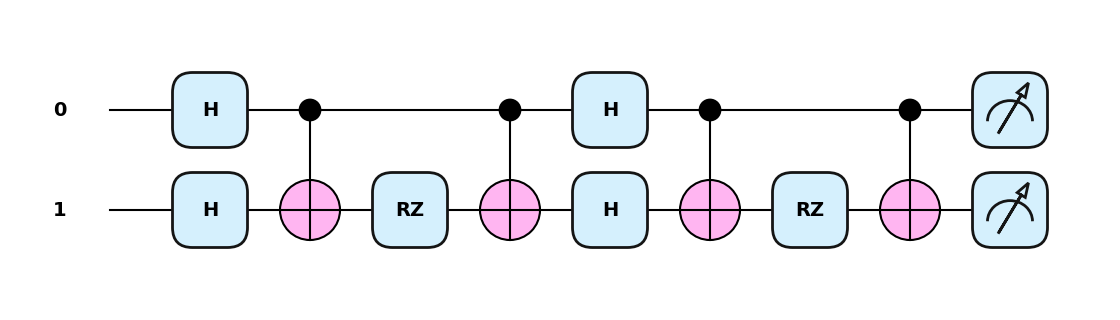

In [290]:
dev = qml.device('default.qubit', wires = 2)

@qml.qnode(dev)
def trotterize(alpha, beta, time, depth = 1):
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires=1)
    ZZ = qml.PauliX(0)@qml.PauliX(1)
    XX = qml.PauliZ(0)@qml.PauliZ(1)
  
    obs = [ZZ, XX]
    coeffs = [alpha, beta]

    H = qml.Hamiltonian(coeffs, obs)
    delta_t = time/depth
    print(H)
    for _ in range(depth):
        for coeff, term in zip(H.coeffs, H.ops):

            opds = term.operands
            t = coeff*delta_t

            for i, op in enumerate(opds):
                if op.name == 'PauliX':

                    qml.Hadamard(wires=i)
            # print(-2*t)
            for j in range(len(opds) -1):           
                qml.CNOT(wires = [j, j+1])
                  
                qml.RZ(-2*t, wires = 1)
            for k in reversed(range(len(opds) -1) ):
                qml.CNOT(wires = [k, k+1])
            for l, op in enumerate(opds):
                if op.name == 'PauliX':

                    qml.Hadamard(wires=l)

    return qml.probs()

qml.draw_mpl(trotterize, style ='pennylane')(0.5,0.8,0.2,1)

#   [0.5,0.8,0.2,1]


In [291]:

trotterize(0.9,1.0,0.4,2)


0.9 * (X(0) @ X(1)) + 1.0 * (Z(0) @ Z(1))


array([0.87590286, 0.        , 0.        , 0.12409714])

In [274]:
import pennylane as qml
from pennylane import numpy as np

# Step 1: Define Hamiltonian
coeffs = [0.5, 0.8]
ops = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
H = qml.Hamiltonian(coeffs, ops)

# Step 2: Set up device
dev = qml.device("default.qubit", wires=2)

# Step 3: Trotterized time evolution circuit
def trotter_step(delta_t):
    for coeff, term in zip(H.coeffs, H.ops):
        opds = term.operands
        for i, op in enumerate(opds):
                if op.name == 'PauliX':

                    qml.Hadamard(wires=i)
        qml.ApproxTimeEvolution(term, delta_t, 1)

@qml.qnode(dev)
def trotterized_circuit(t, depth):
    # Initial state (can be changed)
    
    delta_t = t / depth

    for _ in range(depth):
        trotter_step(delta_t)

    return qml.probs(wires = [0,1])

# Step 4: Run the circuit
time = 0.1
depth = 8

final_state = trotterized_circuit(time, depth)
print("Final state:", final_state)


Final state: [0.99003329 0.         0.         0.00996671]


In [275]:
import pennylane as qml
import numpy as np

# Define the device
dev = qml.device("default.qubit", wires=2)

# Parameters for the Hamiltonian
alpha = 0.5  # Coefficient for PauliZPauliZ
beta = 0.8  # Coefficient for PauliXPauliX

# Define the Hamiltonian terms
H1 = alpha * (qml.PauliZ(0) @ qml.PauliZ(1))  # PauliZPauliZ (on qubits 0 and 1)
H2 = beta * (qml.PauliX(0) @ qml.PauliX(1))   # PauliXPauliX (on qubits 0 and 1)

# Define the time step and total evolution time
delta_t = 0.2  # Time step for each Trotter slice
total_time = 1.0  # Total evolution time
n_steps = int(total_time / delta_t)

# Define the time evolution operator using matrix exponentiation
def time_evolution_operator(H, delta_t):
    # Convert the Hamiltonian operator to its matrix form
    H_matrix = qml.matrix(H)
    
    # Apply the matrix exponential to get the unitary operator
    U_matrix = np.linalg.matrix_power(np.eye(H_matrix.shape[0]) - 1j * H_matrix * delta_t, 1)  # U = exp(-i H delta_t)
    
    return U_matrix

# Define the circuit
@qml.qnode(dev)
def trotterized_circuit():
    # Apply initial state (both qubits in |+> state)
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # Trotterization loop: apply the evolution for each Hamiltonian term
    for _ in range(n_steps):
        # Apply evolution for each term of the Hamiltonian
        U1 = time_evolution_operator(H1, delta_t)
        U2 = time_evolution_operator(H2, delta_t)
        
        # Apply the unitary evolution for each operator
        qml.QubitUnitary(U1, wires=[0, 1])  # Apply to both qubits (0 and 1)
        qml.QubitUnitary(U2, wires=[0, 1])  # Apply to both qubits (0 and 1)
    
    # Return expectation values or any measurement you'd like to track
    return qml.probs()

# Run the simulation
result = trotterized_circuit()
print("Trotterized result:", result)


Trotterized result: [0.29815146 0.29815146 0.29815146 0.29815146]


In [278]:
import pennylane as qml
import numpy as np
import scipy.linalg

# Setup device
dev = qml.device("default.qubit", wires=2, shots=None)

# Parameters
alpha = 0.9
beta = 1.0
total_time = 0.1
depth = 8
delta_t = total_time / depth

# Define Hamiltonian terms
H1 = alpha * (qml.PauliZ(0) @ qml.PauliZ(1))
H2 = beta * (qml.PauliX(0) @ qml.PauliX(1))

# Time evolution operator using matrix exponential
def time_evolution_operator(H, delta_t):
    H_matrix = qml.matrix(H)
    U_matrix = scipy.linalg.expm(-1j * H_matrix * delta_t)
    return U_matrix

# Quantum circuit
@qml.qnode(dev)
def trotterized_circuit():
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    for _ in range(depth):
        U1 = time_evolution_operator(H1, delta_t)
        U2 = time_evolution_operator(H2, delta_t)
        qml.QubitUnitary(U1, wires=[0, 1])
        qml.QubitUnitary(U2, wires=[0, 1])
    
    return qml.probs(wires=[0, 1])

# Run and print results
probs = trotterized_circuit()
for i, p in enumerate(probs):
    print(f"|{i:02b}>: {p:.6f}")


|00>: 0.250000
|01>: 0.250000
|10>: 0.250000
|11>: 0.250000
